In [64]:
from pathlib import Path
from pathlib import *
import pandas as pd
import re
from random import randint
from random import shuffle
import spacy
from time import time
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import gensim
from pprint import pprint
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim import  models
from gensim.test.utils import datapath
nlpd = spacy.load("da_core_news_lg")

# 80'erne simpel topic model
Det følgende script vil søge at lave en topic-model over den danske EU-debat, men hvor domænespecifikke begreber ikke undlades, ligesom at der ikke lades TD-IDF på data.

### Formål
Dette script ønsker konstruere en topic model over 80'ernes EF-debat, og derefter analysere denne models output.

In [65]:
path = "../../Folketingstidende/Hele/"
dir_path = Path(f"{path}")
csv_files = list(dir_path.glob("*.csv"))

In [66]:
csv_files.sort() #sorter så data kommer i rigtig rækkefølge
csv_files[0:5]

[PosixPath('../../Folketingstidende/Hele/19531.csv'),
 PosixPath('../../Folketingstidende/Hele/19541.csv'),
 PosixPath('../../Folketingstidende/Hele/19551.csv'),
 PosixPath('../../Folketingstidende/Hele/19561.csv'),
 PosixPath('../../Folketingstidende/Hele/19562.csv')]

In [67]:
csv_files[35:49]

[PosixPath('../../Folketingstidende/Hele/19801.csv'),
 PosixPath('../../Folketingstidende/Hele/19811.csv'),
 PosixPath('../../Folketingstidende/Hele/19812.csv'),
 PosixPath('../../Folketingstidende/Hele/19821.csv'),
 PosixPath('../../Folketingstidende/Hele/19831.csv'),
 PosixPath('../../Folketingstidende/Hele/19832.csv'),
 PosixPath('../../Folketingstidende/Hele/19841.csv'),
 PosixPath('../../Folketingstidende/Hele/19851.csv'),
 PosixPath('../../Folketingstidende/Hele/19861.csv'),
 PosixPath('../../Folketingstidende/Hele/19862.csv'),
 PosixPath('../../Folketingstidende/Hele/19871.csv'),
 PosixPath('../../Folketingstidende/Hele/19872.csv'),
 PosixPath('../../Folketingstidende/Hele/19881.csv'),
 PosixPath('../../Folketingstidende/Hele/19891.csv')]

In [68]:
Folketingstaler_i_80erne = {}
for fil in csv_files[35:49]:
    if str(fil)[-9:-5] in Folketingstaler_i_80erne:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        for tale in taler:
            Folketingstaler_i_80erne[str(fil)[-9:-5]].append(tale)
    else:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        Folketingstaler_i_80erne[str(fil)[-9:-5]] = []
        for tale in taler:
            Folketingstaler_i_80erne[str(fil)[-9:-5]].append(tale)

In [69]:
def FT_taler(indhold):
    talere = []
    tale = []
    parti = []
    Partier_i_folketinget = ["(A)", "(SF)", "(S)", "(RV)", "(KF)", "(V)", "(FP)", "(CD)", "(VS)",
                             "(KrF)", "(DR)", "(UP)", "(Grønl.)", "(Fær.)"]
    for index in range(len(indhold)):
        sentence = indhold[index]
        if len(re.findall("(^.{1,50} \([A-Z]+\)|^.{1,50} \(KrF\)|^.{1,50} \(Grønl.\)|^.{1,50} \(Fær.\))", sentence)) > 0: #Tjekker om det er et menigt medlem
            if len(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)) < 2:
                if len(re.findall("Ny stedf.", sentence)) > 0:
                    pass
                elif len(re.findall("Udtræder:", sentence)) > 0:
                    pass
                elif len(re.findall("Nyt medl", sentence)) > 0:
                    pass
                elif len(re.findall(" af", sentence.lower())) > 0:
                    pass
                elif re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0] in Partier_i_folketinget:
                    talere.append(sentence)
                    parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0])
                    tale.append("")
                else:
                    if len(tale) >= 1:
                        tale[-1] = tale[-1] + " " + sentence
            else: #ellers er det en tale
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
                #if len(re.findall("(\([A-Z]+\)|\(KrF\))", sentence)) < 2:
        elif sentence.lower() == "formanden" or sentence.lower() == "formanden:": #tjekker om det er formanden der taler
            talere.append("formanden")
            parti.append("Formanden")
            tale.append("")
        elif re.search("næstformand \(\w*\):$", sentence.lower()) or re.search("næstformand \(\w* \w*\):$", sentence.lower()):
            talere.append(sentence.lower())
            parti.append("næstformanden")
            tale.append("")
        elif len(sentence) < 100: #Tjekker om det er en minister der taler
            if len(re.findall("\w*minister[\w ]*\(([\w-]*|[\w ]*)\)", sentence.lower())) > 0:
                talere.append(sentence)
                parti.append("Regeringen")
                tale.append("")
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("[1-9]{1,5} [1-9]{1,2}/[1-9]{1,2}", sentence.lower()))  > 0: #tilføjet til at fange headers på sider
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("^[1-9]{1,2}/[1-9]{1,2}", sentence.lower())) > 0: 
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif re.fullmatch("\[.{1,100}\]", sentence.lower()):
            pass
        elif re.fullmatch("[1-9]{1,10}", sentence.lower()):
            pass
        else:
            if len(tale) >= 1:
                tale[-1] = tale[-1] + " " + sentence
    return tale, talere, parti

In [70]:
Folketingsår_opdelt_per_taler_80erne = {}
for år in Folketingstaler_i_80erne:
    indhold = Folketingstaler_i_80erne[år]
    år_tale, år_talere, år_parti = FT_taler(indhold)
    Folketingsår_opdelt_per_taler_80erne[år] = []
    Folketingsår_opdelt_per_taler_80erne[år].append(år_tale)
    Folketingsår_opdelt_per_taler_80erne[år].append(år_talere)
    Folketingsår_opdelt_per_taler_80erne[år].append(år_parti)

In [71]:
EU_ord = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarked", "ømu", " ef-", " eu-",
          "europæiske samarbejde", "fællesakt", " ømu", "det indre marked"]

In [72]:
eu_taler_80erne = {}
for år in Folketingsår_opdelt_per_taler_80erne:
    #start = time()
    eu_tale_år = []
    eu_parti_år = []
    eu_taler_år = []
    for index in range(len(Folketingsår_opdelt_per_taler_80erne[år][0])):
        tale = Folketingsår_opdelt_per_taler_80erne[år][0][index]
        for ord_ in EU_ord:
            if len(re.findall(ord_, tale.lower())) > 0:
                eu_tale_år.append(tale)
                eu_taler_år.append(Folketingsår_opdelt_per_taler_80erne[år][1][index])
                eu_parti_år.append(Folketingsår_opdelt_per_taler_80erne[år][2][index])
                break
    eu_taler_80erne[år] = []
    eu_taler_80erne[år].append(eu_tale_år)
    eu_taler_80erne[år].append(eu_parti_år)
    eu_taler_80erne[år].append(eu_taler_år)
    #slut = time()
    #print(slut-start) til at time loopsne

In [73]:
for år in eu_taler_80erne:
    print(f"{år}: {len(eu_taler_80erne[år][0])}")

1980: 506
1981: 594
1982: 510
1983: 527
1984: 419
1985: 863
1986: 607
1987: 671
1988: 940
1989: 999


In [74]:
antal_taler_år = [len(eu_taler_80erne[i][0]) for i in eu_taler_80erne]

In [75]:
antal_taler_år

[506, 594, 510, 527, 419, 863, 607, 671, 940, 999]

In [76]:
år_1980erne = [str(1980 + i) for i in range(10)]

In [78]:
#år_1980erne

In [79]:
Alle_taler = []
Alle_taler_år = []
Alle_taler_parti = []
Alle_taler_taler = []
for år in eu_taler_80erne:
    for index in range(len(eu_taler_80erne[år][0])):
        Alle_taler.append(eu_taler_80erne[år][0][index])
        Alle_taler_parti.append(eu_taler_80erne[år][1][index])
        Alle_taler_taler.append(eu_taler_80erne[år][2][index])
        Alle_taler_år.append(år)

In [80]:
len(Alle_taler)

6636

## Klargøring af data

In [81]:
tekster_klar = []
fyldetegn = [",", ".", "(", ")", "?", "/", "!", ":", " ", "):", "-", "«", "»", "[", "]"]
stopord_fil = open('../../Folketingstidende/stopord.txt','r')
stopord = [word[:-1] for word in stopord_fil]

In [82]:
typer_spacy = []
for tegn in fyldetegn:
    tekst_nlpd = nlpd(tegn)
    for token in tekst_nlpd:
        if token.pos_ not in typer_spacy:
            typer_spacy.append(token.pos_)

In [83]:
typer_spacy

['PUNCT', 'X', 'SPACE', 'NOUN', 'SYM']

In [84]:
typer_spacy.remove("NOUN")

In [85]:
for år in eu_taler_80erne:
    #allowed_postags=['NOUN', 'ADJ', 'VERB']
    start = time()
    for tekst in eu_taler_80erne[år][0]:
        tale_spacy = nlpd(tekst.lower())
        #tokens = [str(token.lemma_).lower() for token in tale_spacy]
        tokens = [token for token in tale_spacy]
        tokens_uden_tegn = [str(token) for token in tokens if token.pos_ not in typer_spacy]
        #tokens_uden_stopord = [token for token in tokens_uden_tegn if token not in stopord]
        tekster_klar.append(tokens_uden_tegn)
    end = time()
    #print(end-start)

In [86]:
processed_data = []
for tekst in tekster_klar:
    str_tekst = [str(token) for token in tekst]
    processed_data.append(str_tekst)

In [87]:
len(processed_data)

6636

In [88]:
bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)

trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)

In [90]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stopord] for doc in texts]
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def create_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatize(texts, allowed_postags=[ 'NOUN', 'ADJ', 'VERB', 'PROPN']):
    texts_op = []
    start = time()
    for sent in texts:
        doc = nlpd(" ".join(sent))
        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    end = time()
    #print(end-start)
    return texts_op

In [91]:
#removing stopwords, creating bigrams and lemmatizing the text

data_wo_stopwords = remove_stopwords(processed_data)

data_bigrams = create_bigrams(data_wo_stopwords)

data_lemmatized = lemmatize(data_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'PROPN', 'ADV'])

stopwords_removed_2 = remove_stopwords(data_lemmatized) #Jeg prøver at sortere stopord fra igen

#shuffle(stopwords_removed_2)

data_lemmatized = stopwords_removed_2

In [92]:
#gensim_dictionary = corpora.Dictionary(data_lemmatized) #uden shuffle

#texts = data_lemmatized

#gensim_corpus_ikke_random = [gensim_dictionary.doc2bow(text) for text in texts] #uden_shuffle

In [93]:
len(data_lemmatized)

6636

In [94]:
#gensim_dictionary = corpora.Dictionary(data_lemmatized)

texts = [text for text in data_lemmatized]

shuffle(texts)

gensim_dictionary = corpora.Dictionary(texts)

gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

In [95]:
#gensim_dictionary.save("Dictionaries/1980_erne/LDA_1980_21_topics_simple_02_10_22_nummer_4_ikke_afgift_dictionary")

In [96]:
gensim_dictionary = corpora.Dictionary.load("Dictionaries/1980_erne/LDA_1980_23_topics_simple_02_10_22_nummer_2_bedre_dictionary")

In [199]:
#gensim_dictionary.save("Dictionaries/Dictionaries_opgaven/1980_erne")

In [26]:
#shuffle(gensim_corpus)

In [97]:
gensim_corpus_ikke_random = [gensim_dictionary.doc2bow(text) for text in data_lemmatized]

## Coherence model

Evaluering af bedste model

In [98]:
def compute_coherence_values(k):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus,
                                           id2word=gensim_dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=gensim_dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [99]:
# Topics range
#min_topics = 17
#max_topics = 25
#step_size = 1
#topics_range = range(min_topics, max_topics, step_size)

#empty dataframe
#model_results = {'Topics': [],
#                 'Coherence': []
#                }

# iterate through number of topics
#for k in topics_range:
#    print(k)
#    # get the coherence score for the given topics
#    cv = compute_coherence_values(k=k)
#    # Save the model results
#    model_results['Topics'].append(k)
#    model_results['Coherence'].append(cv)

In [100]:
#fig, ax = plt.subplots()
#ax.plot(model_results["Topics"], model_results['Coherence'])
#ax.set_title("Simple model")

In [101]:
#model_results['Coherence'].index(max(model_results['Coherence']))

In [102]:
#max(model_results['Coherence'])

In [103]:
#lda_model = gensim.models.ldamodel.LdaModel(corpus = gensim_corpus,
#                                            id2word = gensim_dictionary,
#                                            num_topics = 19,
#                                            random_state = 100,
#                                            update_every = 1,
#                                            chunksize = 100,
#                                            passes = 10,
#                                            alpha = "auto",
#                                            )

Jeg gemmer nu denne topic model.

In [104]:
#temp_file = datapath("LDA_1980_22_topics_simple_30_09_22_med_adv_random")
#lda_model.save(temp_file) #den er gemt en enkelt gang

In [105]:
#"LDA_1980_23_topics_simple_30_09_22_med_adv_random"

In [106]:
lda_model = models.ldamodel.LdaModel.load("Modeller/1980_erne/LDA_1980_23_topics_simple_02_10_22_nummer_2_bedre")

In [107]:
pprint(lda_model.show_topics(-1))

[(0,
  '0.038*"redegørelse" + 0.021*"område" + 0.017*"forskning" + 0.017*"mulighed" '
  '+ 0.016*"behov" + 0.016*"støtte" + 0.015*"indsats" + 0.014*"projekt" + '
  '0.013*"yde" + 0.012*"kvinde"'),
 (1,
  '0.069*"udenrigsminister" + 0.047*"sovjetunionen" + 0.030*"sydafrika" + '
  '0.024*"sanktion" + 0.022*"pol" + 0.021*"fn" + 0.019*"støtte" + 0.018*"vest" '
  '+ 0.018*"situation" + 0.018*"usa"'),
 (2,
  '0.020*"regering" + 0.017*"danmark" + 0.015*"spørgsmål" + 0.013*"ef" + '
  '0.012*"give" + 0.012*"folketing" + 0.011*"ønske" + 0.011*"land" + '
  '0.010*"dag" + 0.009*"side"'),
 (3,
  '0.049*"land" + 0.048*"samarbejde" + 0.035*"udvikling" + 0.017*"arbejde" + '
  '0.015*"danmark" + 0.013*"europa" + 0.012*"område" + 0.010*"år" + '
  '0.010*"østeuropa" + 0.010*"initiativ"'),
 (4,
  '0.095*"grønland" + 0.054*"fiskeri" + 0.024*"færøerne" + 0.022*"fisker" + '
  '0.021*"kvote" + 0.020*"fiskeriminister" + 0.019*"bemyndigelse" + 0.017*"ef" '
  '+ 0.017*"grønlands" + 0.016*"tredjeland"'),
 (5,
  '

In [198]:
lda_model.save("Modeller/Modeller_til_opgaven/Model_1980")

## Tildeling af emne til tekster

In [108]:
topics = []
for index in range(len(data_lemmatized)):
    sand_top = 0
    best_topic = 0
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if sand > sand_top:
            sand_top = sand
            best_topic = topic
    topics.append(best_topic)

In [109]:
def count_topics(topics, antal_topics):
    forskellige_topics = [i for i in range(antal_topics)]
    antal_af_hver_topic = [0 for i in range(antal_topics)]
    for topic in topics:
        antal_af_hver_topic[topic] += 1
    return [forskellige_topics, antal_af_hver_topic]

In [110]:
resultat = count_topics(topics, 23)

In [111]:
#for topic in resultat[0]:
#    print(f"Topic {topic}: {resultat[1][topic]}")

### Undersøgelse af topic 1: 

In [113]:
topics_1 = []
topics_1_sand = []
for index in range(len(data_lemmatized)):
    sand_top = 0
    best_topic = 0
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 1:
            topics_1.append(index)
            topics_1_sand.append(sand)

            topics.append(best_topic)

In [114]:
#topics_1

In [197]:
print(Alle_taler_taler[3687])
print(Alle_taler_parti[3687])
print(Alle_taler_år[3687])
#Alle_taler[3687]

Lone Dybkjær (RV):
(RV)
1986


## Generelt semantically opague:
Topics 13 og 21:

### Topic 13

In [116]:
topics_13 = []
topics_13_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 13:
            topics_13.append(index)
            topics_13_sand.append(sand)
    topics.append(best_topic)
len(topics_13)

47

In [117]:
topics_13_høj_sand = [topics_13[i] for i in range(len(topics_13)) if topics_13_sand[i]>0.05]
len(topics_13_høj_sand)

0

In [118]:
#random_tal= randint(0, len(topics_13_høj_sand)-1)
#random_index = topics_13_høj_sand[random_tal]
#print(Alle_taler_år[random_index])
#print(Alle_taler_taler[random_index])
#print(Alle_taler_parti[random_index])
#print(Alle_taler[random_index])

### Topic 21:

In [119]:
topics_21 = []
topics_21_sand = []
for index in range(len(gensim_corpus)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 21:
            topics_21.append(index)
            topics_21_sand.append(sand)
    topics.append(best_topic)
len(topics_21)

185

In [120]:
topics_21_høj_sand = [topics_21[i] for i in range(len(topics_21)) if topics_21_sand[i]>0.05]
len(topics_21_høj_sand)

13

In [196]:
random_tal= randint(0, len(topics_21_høj_sand)-1)
random_index = topics_21_høj_sand[random_tal]
print(Alle_taler_år[random_index])
print(Alle_taler_taler[random_index])
print(Alle_taler_parti[random_index])
#print(Alle_taler[random_index])

1986
Tinning (VS):
(VS)


### Fiskeri og Grønland

In [122]:
topics_fiskeri = []
topics_fiskeri_sand = []
for index in range(len(Alle_taler)):
    sand_top = 0
    best_topic = 0
    eu_tale_topic_distribution = lda_model.get_document_topics(gensim_dictionary.doc2bow(data_lemmatized[index]))
    for topic, sand in eu_tale_topic_distribution:
        if topic == 4:
            topics_fiskeri.append(index)
            topics_fiskeri_sand.append(sand)

In [123]:
len(topics_fiskeri_sand)

1120

In [126]:
topics_fiskeri_sand.index(min(topics_fiskeri_sand))

838

In [127]:
topics_fiskeri_høj_sand = [topics_fiskeri[i] for i in range(len(topics_fiskeri)) if topics_fiskeri_sand[i]>0.1]

In [128]:
len(topics_fiskeri_høj_sand)

201

In [129]:
len(topics_fiskeri_høj_sand)

201

In [130]:
fiskeri_ef_år = [Alle_taler_år[index] for index in topics_fiskeri]

In [131]:
år_1980erne = list(set(fiskeri_ef_år))
år_1980erne.sort()
år_1980erne

['1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989']

In [132]:
folketingsår = [str(80 + i) + "/" + str(80 + i + 1) for i in range(10)]

In [133]:
folketingsår

['80/81',
 '81/82',
 '82/83',
 '83/84',
 '84/85',
 '85/86',
 '86/87',
 '87/88',
 '88/89',
 '89/90']

In [134]:
antal_taler_1980eren_fiskeri = []
for år in år_1980erne:
    antal_taler_1980eren_fiskeri.append(fiskeri_ef_år.count(år))

In [135]:
antal_taler_1980eren_fiskeri

[110, 153, 92, 142, 58, 102, 96, 113, 114, 140]

In [136]:
fiskeri_andel = [antal_taler_1980eren_fiskeri[i]/antal_taler_år[i] for i in range(10)]

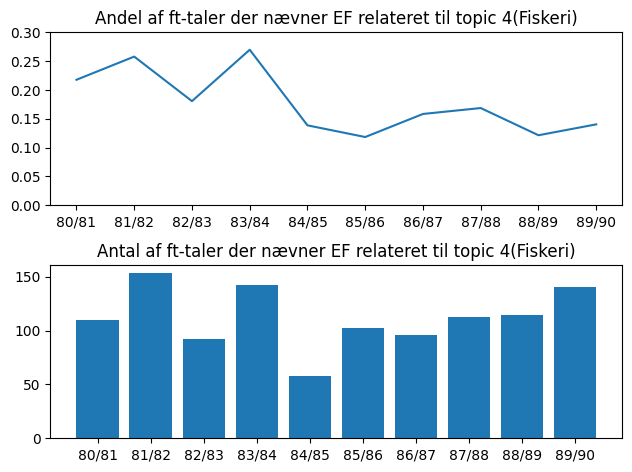

In [137]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 4(Fiskeri)")
ax1.plot(folketingsår, fiskeri_andel)
ax1.set_ylim([0, 0.3])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 4(Fiskeri)")
ax2.bar(folketingsår, antal_taler_1980eren_fiskeri)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_4")

### Grønland 1986/1987

In [139]:
Grønland_taler_høj_1986 = [i for i in topics_fiskeri_høj_sand if Alle_taler_år[i] == "1986"]

In [140]:
len(Grønland_taler_høj_1986)

16

In [141]:
random_tal= randint(0, len(Grønland_taler_høj_1986))
random_index = Grønland_taler_høj_1986[random_tal]
print(Alle_taler_år[random_index])
print(Alle_taler_parti[random_index])
print(Alle_taler_taler[random_index])
#print(Alle_taler[random_index])

1986
(S)
Arne Jensen (S):


## Miljø

In [142]:
topics_miljø = []
topics_miljø_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 16:
            topics_miljø.append(index)
            topics_miljø_sand.append(sand)

In [143]:
len(topics_miljø)

922

In [144]:
topic_miljø_høj_sand = [topics_miljø[i] for i in range(len(topics_miljø)) if topics_miljø_sand[i] >= 0.1]
len(topic_miljø_høj_sand)

45

In [195]:
random_tal= randint(0, len(topic_miljø_høj_sand))
random_index = topic_miljø_høj_sand[random_tal]
print(Alle_taler_år[random_index])
print(Alle_taler_parti[random_index])
#print(Alle_taler[random_index])

1986
(SF)


In [147]:
Miljø_taler_år = [Alle_taler_år[i] for i in topics_miljø]
Miljø_antal_taler_1980eren = []

for år in år_1980erne:
    Miljø_antal_taler_1980eren.append(Miljø_taler_år.count(år))
miljø_andel = [Miljø_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

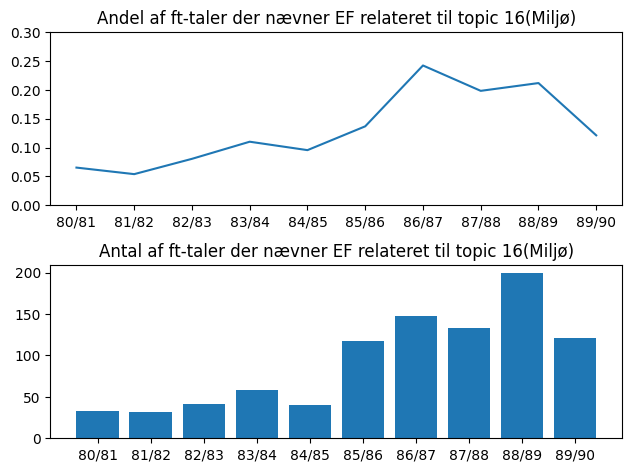

In [148]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 16(Miljø)")
ax1.plot(folketingsår, miljø_andel)
ax1.set_ylim([0, 0.3])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 16(Miljø)")
ax2.bar(folketingsår, Miljø_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_16")

In [149]:
høj_sandsynlighed_1980 = []
for index in topic_miljø_høj_sand:
    if Alle_taler_år[index] == "1988":
        høj_sandsynlighed_1980.append(index)
len(høj_sandsynlighed_1980)

6

In [150]:
randint(0, len(høj_sandsynlighed_1980))

5

In [151]:
random_tal= randint(0, len(høj_sandsynlighed_1980)-1)
random_index = høj_sandsynlighed_1980[random_tal]
print()
print(Alle_taler_år[random_index])
print(Alle_taler_parti[random_index])
#print(Alle_taler[random_index])


1988
(S)


## Landbrug

In [152]:
topics_landbrug = []
topics_landbrug_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 15:
            topics_landbrug.append(index)
            topics_landbrug_sand.append(sand)
len(topics_landbrug)

738

In [153]:
topic_landbrug_høj_sand = [topics_landbrug[i] for i in range(len(topics_landbrug)) if topics_landbrug_sand[i] >= 0.1]
len(topic_landbrug_høj_sand)

86

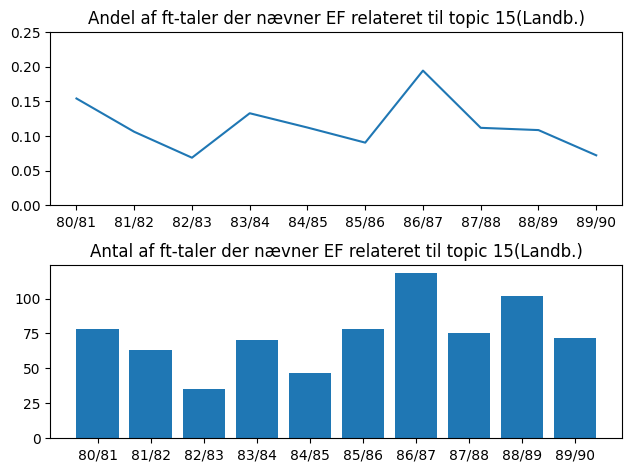

In [154]:
landbrug_taler_år = [Alle_taler_år[i] for i in topics_landbrug]
landbrug_antal_taler_1980eren = []

for år in år_1980erne:
    landbrug_antal_taler_1980eren.append(landbrug_taler_år.count(år))
landbrug_andel = [landbrug_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 15(Landb.)")
ax1.plot(folketingsår, landbrug_andel)
ax1.set_ylim([0, 0.25])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 15(Landb.)")
ax2.bar(folketingsår, landbrug_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_15")
#ax.plot(år_1980erne, landbrug_andel)

In [155]:
landbrug_antal_taler_1980eren

[78, 63, 35, 70, 47, 78, 118, 75, 102, 72]

### Undersøgelse af 86/87

In [156]:
topic_landbrug_høj_sand_1986 = [i for i in topic_landbrug_høj_sand if Alle_taler_år[i] == "1986"]
topic_landbrug_1986 = [i for i in topics_landbrug if Alle_taler_år[i] == "1986"]
print(len(topic_landbrug_1986))
len(topic_landbrug_høj_sand_1986)

118


7

In [157]:
random_tal= randint(0, len(topic_landbrug_høj_sand_1986)-1)
random_index = topic_landbrug_høj_sand_1986[random_tal]
print(Alle_taler_taler[random_index])
print(Alle_taler_år[random_index])
print(Alle_taler_parti[random_index])
print(Alle_taler[random_index])

Ove Jensen (FP):
1986
(FP)
 Nu skal det ikke være en EF-diskussion, men alle ved, at Danmark henter adskillige milliarder kroner hvert år på grundlag af vort EF-medlemskab. Derfor ville landbruget selvfølgelig have været endnu dårligere stillet, hvis vi ikke havde været medlem af EF. Forholdet imellem dansk landbrug og de øvrige EF-landes landbrug er, at det har været en bedre forretning for de øvrige EF-lan- des landmænd at producere, end det har været her i Danmark. Det er årsagen til, at den produktionsudvidelse af landbrugsprodukter, der er sket i Fællesmarkedet, er sket i de andre lande, f.eks. i Holland, hvorimod produktionen i Danmark har været stagnerende og nu altså er på vej til at blive helt udslettet, som jeg tidligere har gjort opmærksom på.


### Landbrug og miljø:

In [158]:
Landbrug_og_miljø_1986 = [i for i in topic_landbrug_1986 if i in topics_miljø]
len(Landbrug_og_miljø_1986)

52

In [159]:
Landbrug_og_miljø = [i for i in topics_landbrug if i in topics_miljø]

In [160]:
len(Landbrug_og_miljø)

209

In [161]:
Landbrug_og_miljø_år = [Alle_taler_år[i] for i in Landbrug_og_miljø]
Landbrug_og_miljø_antal_taler_1980eren = []

for år in år_1980erne:
    Landbrug_og_miljø_antal_taler_1980eren.append(Landbrug_og_miljø_år.count(år))
Landbrug_og_miljø_antal_taler_1980eren

[6, 8, 2, 8, 7, 23, 52, 33, 45, 25]

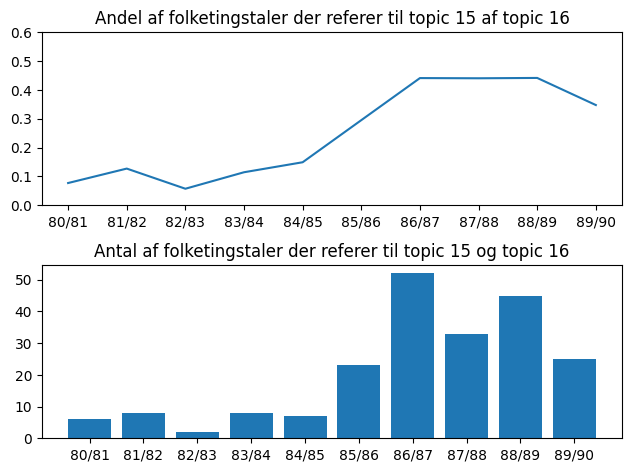

In [163]:
Landbrug_og_miljø_andel = [Landbrug_og_miljø_antal_taler_1980eren[i]/landbrug_antal_taler_1980eren[i] for i in range(10)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der referer til topic 15 af topic 16")
ax1.plot(folketingsår, Landbrug_og_miljø_andel)
ax1.set_ylim([0, 0.60])
ax2.set_title("Antal af folketingstaler der referer til topic 15 og topic 16")
ax2.bar(folketingsår, Landbrug_og_miljø_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_referer_til_topic_15_af_topic_16_med_total")
ax.plot(år_1980erne, landbrug_andel)

(0.0, 0.55)

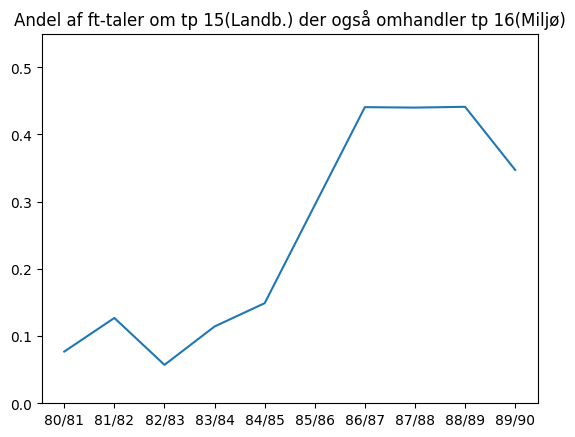

In [164]:
fig, ax = plt.subplots()
ax.set_title("Andel af ft-taler om tp 15(Landb.) der også omhandler tp 16(Miljø)")
ax.plot(folketingsår, Landbrug_og_miljø_andel)
ax.set_ylim([0, 0.55])
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_referer_til_topic_15_af_topic_16")

### Arbejdsmiljø

In [165]:
topics_arbejds_miljø = []
topics_arbejds_miljø_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 18:
            topics_arbejds_miljø.append(index)
            topics_arbejds_miljø_sand.append(sand)

In [166]:
len(topics_arbejds_miljø)

1344

In [167]:
arbejds_miljø_taler_år = [Alle_taler_år[i] for i in topics_arbejds_miljø]
arbejds_miljø_taler_1980eren = []

for år in år_1980erne:
    arbejds_miljø_taler_1980eren.append(arbejds_miljø_taler_år.count(år))
arbejds_miljø_andel = [arbejds_miljø_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

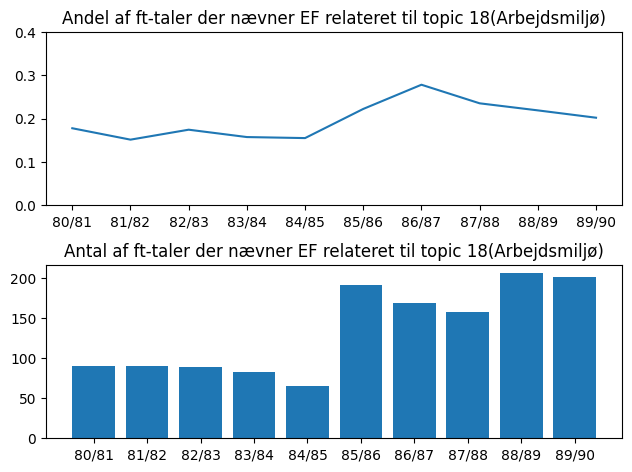

In [169]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 18(Arbejdsmiljø)")
ax1.plot(folketingsår, arbejds_miljø_andel)
ax1.set_ylim([0, 0.4])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 18(Arbejdsmiljø)")
ax2.bar(folketingsår, arbejds_miljø_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_18")

### Undersøgelse af stof i arbejdsmiljø

In [170]:
topics_arbejds_miljø_sand.index(max(topics_arbejds_miljø_sand))

562

In [171]:
topics_arbejds_miljø_sand_til_sort = [sand for sand in topics_arbejds_miljø_sand]

In [172]:
topics_arbejds_miljø_sand_til_sort.sort(reverse = True)

In [173]:
topics_arbejds_miljø_sand.index(topics_arbejds_miljø_sand_til_sort[4])

86

In [174]:
topics_arbejds_miljø[476]

2825

In [176]:
print(Alle_taler_taler[4385])
print(Alle_taler_år[4385])
#Alle_taler[4385]

Af Dorte Bennedsen (S) m.fl.
1987


## Afgift

In [177]:
topics_afgift = []
topics_afgift_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 9:
            topics_afgift.append(index)
            topics_afgift_sand.append(sand)
len(topics_afgift)

912

In [178]:
afgift_høj_sand = [topics_afgift[i] for i in range(len(topics_afgift)) if topics_afgift_sand[i] >= 0.05]

In [179]:
len(afgift_høj_sand)

151

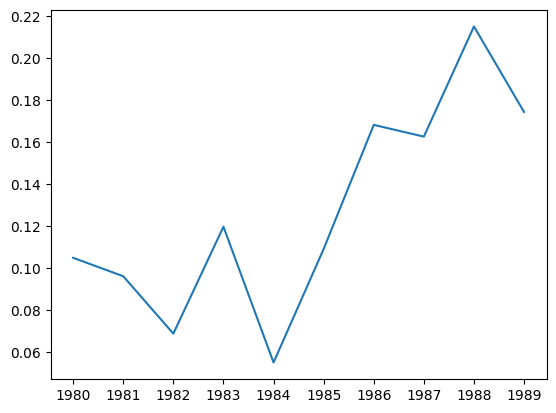

In [180]:
topics_afgift_år = [Alle_taler_år[i] for i in topics_afgift]
afgift_antal_taler_1980eren = []

for år in år_1980erne:
    afgift_antal_taler_1980eren.append(topics_afgift_år.count(år))
afgift_andel = [afgift_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]
fig, ax = plt.subplots()
ax.plot(år_1980erne, afgift_andel)

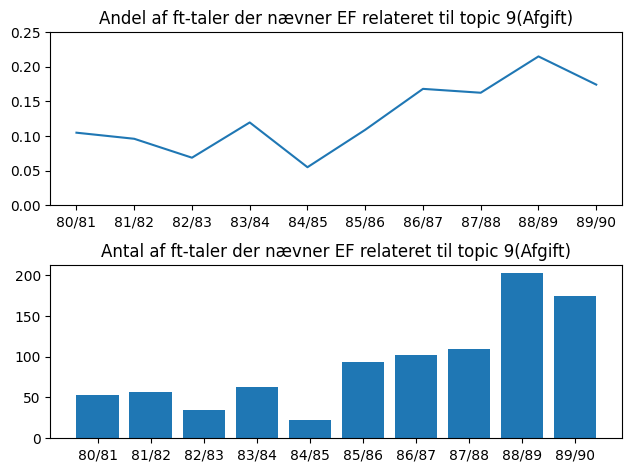

In [182]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 9(Afgift)")
ax1.plot(folketingsår, afgift_andel)
ax1.set_ylim([0, 0.25])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 9(Afgift)")
ax2.bar(folketingsår, afgift_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_9")

### Topic 12 om ef:

In [183]:
topics_ef_12 = []
topics_ef_12_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 12:
            topics_ef_12.append(index)
            topics_ef_12_sand.append(sand)
len(topics_afgift)

912

In [184]:
topics_ef_12_år = [Alle_taler_år[i] for i in topics_ef_12]
ef_12_antal_taler_1980eren = []

for år in år_1980erne:
    ef_12_antal_taler_1980eren.append(topics_ef_12_år.count(år))
ef_12_andel = [ef_12_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

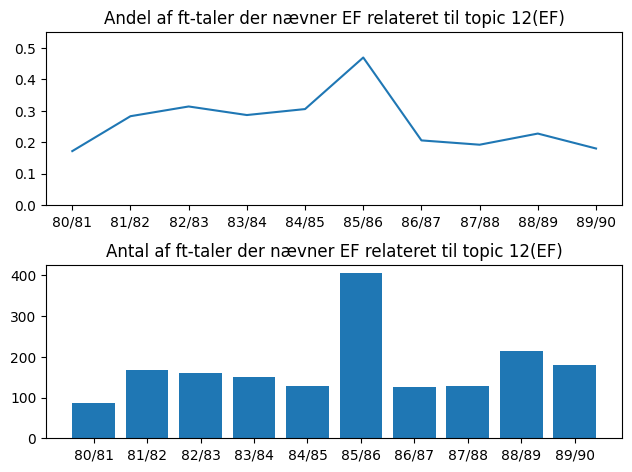

In [185]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 12(EF)")
ax1.plot(folketingsår, ef_12_andel)
ax1.set_ylim([0, 0.55])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 12(EF)")
ax2.bar(folketingsår, ef_12_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
#fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_12")

In [186]:
#undersøgelse af EF_pakken

In [187]:
ef_pakken = []
for tale in data_lemmatized:
    if "ef-pakken" in tale:
        ef_pakken.append(tale)
len(ef_pakken)

234

In [188]:
antal_ef_pakken_topic_12 = 0
for tale in ef_pakken:
    bow = gensim_dictionary.doc2bow(tale)
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 12:
            antal_ef_pakken_topic_12 += 1
antal_ef_pakken_topic_12

213

### Mangler: Udvidelse

In [189]:
Lande = ["spanien", "portugal"]
taler_spanien_portugal = []
for index in range(len(Alle_taler)):
    tale = Alle_taler[index]
    for land in Lande:        
        if len(re.findall(land, tale.lower())) > 0:
            taler_spanien_portugal.append(index)
            break
        

In [190]:
len(taler_spanien_portugal)

209

In [191]:
taler_spanien_portugal_år = [Alle_taler_år[i] for i in taler_spanien_portugal]

In [192]:
for år in eu_taler_80erne:
    taler_spanien_portugal_år.count(år)

In [193]:
Antal_per_år = [taler_spanien_portugal_år.count(år) for år in eu_taler_80erne]

In [194]:
Antal_per_år

[10, 24, 3, 21, 17, 46, 15, 26, 29, 18]